In [1]:
from src.model import VAE
from src.trainer import SimCLRTrainer
from src.model import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
import numpy as np

from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%load_ext autoreload
%autoreload 2

In [2]:
from corruption_utils import corruptions

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)

In [5]:
class CMNISTGenerator:
    def __init__(self, dataset: torchvision.datasets.MNIST, corruption_fns: None | dict) -> None:
        self.dataset = dataset
        self.corruption_fns = corruption_fns
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        if self.corruption_fns is not None:
            cfn = np.random.choice(
                list(self.corruption_fns.keys()), p=list(self.corruption_fns.values())
            )
            img = cfn(img)
            return img, label
        else:
            return img, label

    @property
    def size(self):
        return len(self.dataset)
    
class CMNIST(Dataset):

    def __init__(self, generator, transform) -> None:
        super().__init__()
        self.generator = generator
        self.transform = transform
        self.N = generator.size
        self.dataset = [None] * self.N
        with tqdm(range(self.N), unit="item") as bar:
            bar.set_description("Generating dataset")
            for i in bar:
                self.dataset[i] = self.generator[i]

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx) -> tuple:
        img, label = self.dataset[idx]
        img = self.transform(img)
        return img, label
    
    def display(self, idx):
        img, _ = self.__getitem__(idx)
        display(transforms.ToPILImage()(img))

In [6]:
generator = CMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.3,
        corruptions.stripe: 0.3,
        corruptions.zigzag: 0.3,
        corruptions.canny_edges: 0.1,
    },
)


In [7]:
dataset = CMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)


Generating dataset: 100%|██████████| 60000/60000 [00:10<00:00, 5952.68item/s]


### cosine

In [56]:
vae = VAE(z_dim=16).to(device)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = SimCLRTrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": 0.3, "beta": 20},
    verbose_period=5,
    device=device,
)

In [57]:
trainer.fit(dataloader, 26)

Epoch 25: 100%|██████████| 469/469 [00:04<00:00, 113.74batch/s, c_loss=0.268, vae_loss=14.3]


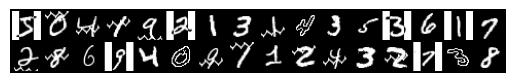

In [58]:
vae.eval()

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
X, label = next(iter(dataloader))
X = X.to(device)
label = label.to(device)

X_hat, latent_params, z = vae(X, explicit=True)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


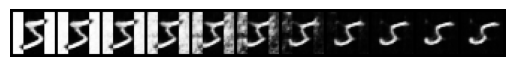

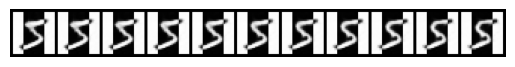

In [59]:
with torch.no_grad():
    idx1, idx2 = 0, 11
    z1, z2 = z[idx1], z[idx2]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))
    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


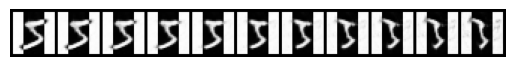

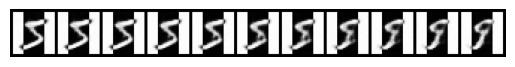

In [62]:
with torch.no_grad():
    idx1, idx2 = 0, 14
    
    z1, z2 = z[idx1], z[idx2]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))
    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


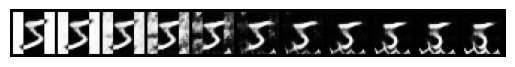

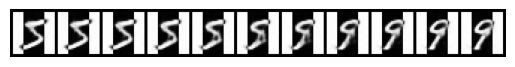

In [61]:
with torch.no_grad():
    idx1, idx2 = 0, 4
    z1, z2 = z[idx1], z[idx2]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))
    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


### cosine-var-adjust

In [14]:
vae = VAE(z_dim=16).to(device)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = SimCLRTrainer(vae, optimizer, sim_fn="cosine-var-adjust", verbose_period=2, device=device)

In [ ]:
trainer.fit(dataloader, 11)

In [43]:
%%capture
vae.eval()

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
X, label = next(iter(dataloader))
X = X.to(device)
label = label.to(device)

X_hat, latent_params, z = vae(X, explicit=True)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


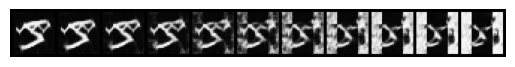

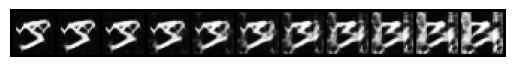

In [44]:
with torch.no_grad():
    idx1, idx2 = 0, 11
    z1, z2 = z[idx1], z[idx2]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))
    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


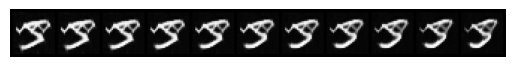

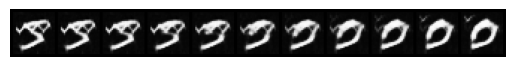

In [45]:
with torch.no_grad():
    idx1, idx2 = 0, 1
    z1, z2 = z[idx1], z[idx2]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))
    
    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


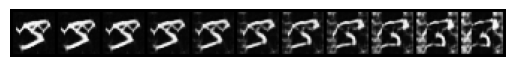

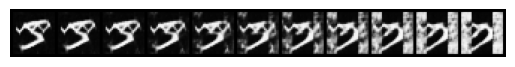

In [46]:
with torch.no_grad():
    idx1, idx2 = 0, 2
    z1, z2 = z[idx1], z[idx2]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))
    
    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


### BC

In [24]:
vae = VAE(z_dim=16).to(device)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = SimCLRTrainer(vae, optimizer, sim_fn="bhattacharyya-coef", verbose_period=2, device=device)

In [26]:
torch.autograd.set_detect_anomaly(True)
trainer.fit(dataloader, 21)

Epoch 20: 100%|██████████| 469/469 [00:44<00:00, 10.43batch/s, c_loss=2.31, vae_loss=14.5]


In [27]:

vae.eval()

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
X, label = next(iter(dataloader))
X = X.to(device)
label = label.to(device)

X_hat, latent_params, z = vae(X, explicit=True)



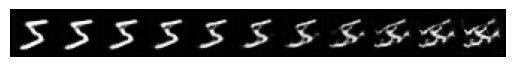

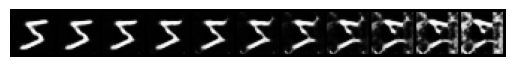

In [28]:
with torch.no_grad():
    idx1, idx2 = 0, 11
    z1, z2 = z[idx1], z[idx2]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))
    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


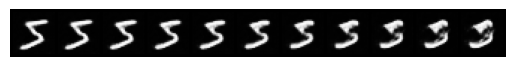

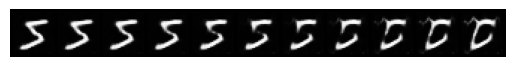

In [29]:
with torch.no_grad():
    idx1, idx2 = 0, 1
    z1, z2 = z[idx1], z[idx2]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))
    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()


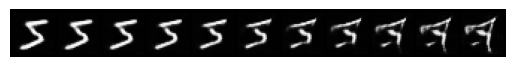

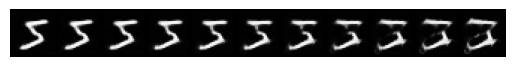

In [30]:
with torch.no_grad():
    idx1, idx2 = 0, 2
    z1, z2 = z[idx1], z[idx2]
    display(transforms.ToPILImage()(vae.decode(z1.view(1, -1))[0]))
    display(transforms.ToPILImage()(vae.decode(z2.view(1, -1))[0]))
    
    z_inter = interpolate_latent(latent1=z1[16:], latent2=z2[16:], num_steps=11, device=device)
    z_combined = torch.cat([z1[:16][None, :].repeat(11, 1), z_inter], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

    z_inter = interpolate_latent(latent1=z1[:16], latent2=z2[:16], num_steps=11, device=device)
    z_combined = torch.cat([z_inter, z1[16:][None, :].repeat(11, 1)], dim=1)
    x_inter = vae.decode(z_combined)
    plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()
